In [ ]:
import photutils
print(photutils.__version__)

2.0.1


In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import get_pkg_data_filename
!pip install photutils #only needed if its being run on colabs
from photutils.centroids import centroid_2dg
from scipy.ndimage import shift
from photutils.background import Background2D, MedianBackground
from astropy.stats import SigmaClip

In [ ]:
# Directory path
dir = "/content/sample_data/"

# File names for each filter
filename_R = f"{dir}m57_Red_mask_combined.fits"
filename_G = f"{dir}m57_Green_mask_combined.fits"
filename_B = f"{dir}m57_Blue_mask_combined.fits"

# Load data for each channel
data_R = fits.getdata(filename_R)
data_G = fits.getdata(filename_G)
data_B = fits.getdata(filename_B)

In [ ]:
pos_R = [150,275]
pos_G = [115,370]
pos_B = [100,435]

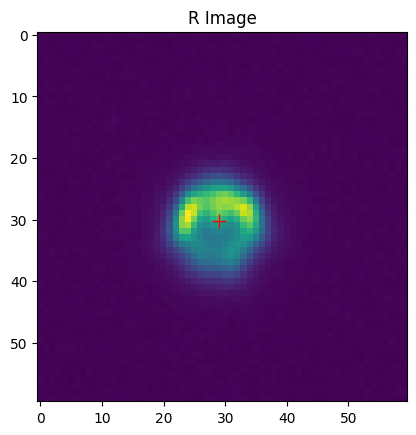

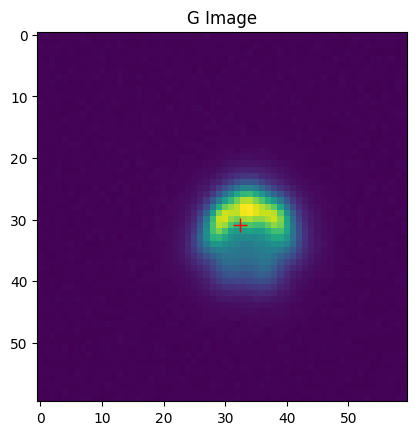

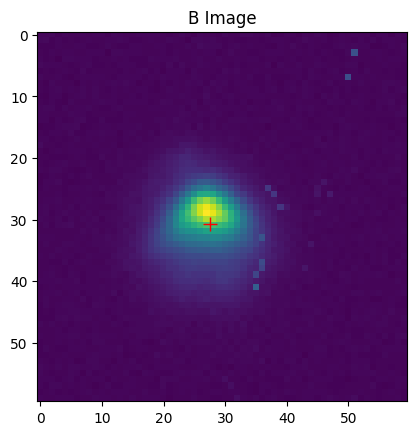

In [ ]:
subdata_R = data_R[pos_R[1]-30:pos_R[1]+30, pos_R[0]-30:pos_R[0]+30]
subdata_G = data_G[pos_G[1]-30:pos_G[1]+30, pos_G[0]-30:pos_G[0]+30]
subdata_B = data_B[pos_B[1]-30:pos_B[1]+30, pos_B[0]-30:pos_B[0]+30]

# Display the sub-image
plt.imshow(subdata_R)
plt.title(f"R Image")

# Show centroid
plt.plot(centroid_2dg(subdata_R)[0], centroid_2dg(subdata_R)[1], 'r+', markersize=10, label='Centroid')
plt.show()

# Calculate centroid
center_2dg_R = centroid_2dg(subdata_R) + pos_R - [30, 30]

# Display the sub-image
plt.imshow(subdata_G)
plt.title(f"G Image")

# Show centroid
plt.plot(centroid_2dg(subdata_G)[0], centroid_2dg(subdata_G)[1], 'r+', markersize=10, label='Centroid')
plt.show()

# Calculate centroid
center_2dg_G = centroid_2dg(subdata_G) + pos_G - [30, 30]

# Display the sub-image
plt.imshow(subdata_B)
plt.title(f"B Image")

# Show centroid
plt.plot(centroid_2dg(subdata_B)[0], centroid_2dg(subdata_B)[1], 'r+', markersize=10, label='Centroid')
plt.show()

# Calculate centroid
center_2dg_B = centroid_2dg(subdata_B) + pos_B - [30, 30]

In [ ]:
shift_G_y = -int(np.round(center_2dg_G[1]-center_2dg_R[1]))
shift_G_x = -int(np.round(center_2dg_G[0]-center_2dg_R[0]))

shift_B_y = -int(np.round(center_2dg_B[1]-center_2dg_R[1]))
shift_B_x = -int(np.round(center_2dg_B[0]-center_2dg_R[0]))

mask_y1 = min(shift_G_y, shift_B_y, 0)
mask_y2 = max(shift_G_y, shift_B_y, 0)

mask_x1 = min(shift_G_x, shift_B_x, 0)
mask_x2 = max(shift_G_x, shift_B_x, 0)

# Shift the image using scipy.ndimage.shift
shifted_G = shift(data_G, (shift_G_y, shift_G_x), mode='constant', cval=0.0)
shifted_B = shift(data_B, (shift_B_y, shift_B_x), mode='constant', cval=0.0)


2568.1181109939457
      Median background found (Red): 2556.862191, median bkg noise: 40.533200


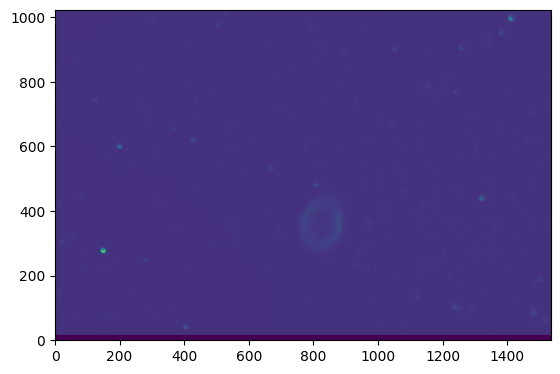

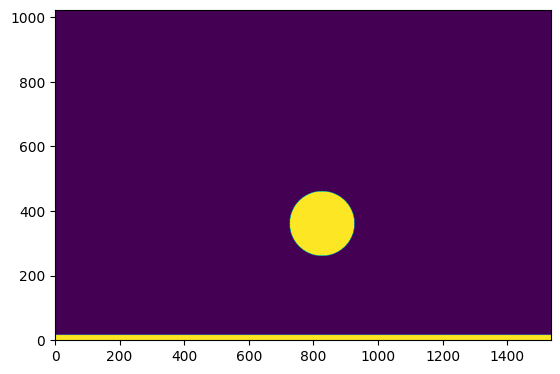

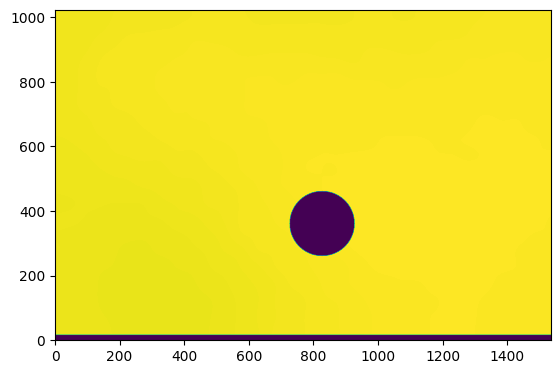

In [ ]:
# Red filter
mask_R = np.zeros(np.shape(data_R))
mask_R = mask_R.astype(bool)

# Define the center and radius for the circular mask
center_x, center_y = 825, 360
radius = 100

# Create a grid of indices
y_indices, x_indices = np.indices(np.shape(data_R))

# Calculate the distance from the center for each pixel
distance = np.sqrt((x_indices - center_x)**2 + (y_indices - center_y)**2)

# Set the mask to True within the radius
mask_R[distance <= radius] = True

# Additionally, set the mask to True for all pixels in data_R that are 0
mask_R[data_R == 0] = True

# Create background estimation
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg_R = Background2D(data_R, (50, 50), filter_size=(3, 3), sigma_clip=sigma_clip,
                     bkg_estimator=bkg_estimator, coverage_mask=mask_R)

# Find the pixels just outside the circle (10 pixels outside)
surrounding_mask = (distance > radius) & (distance <= radius + 10)

# Extract the pixel values from bkg_R.background in the surrounding region
surrounding_values = bkg_R.background[surrounding_mask]

# Calculate the average of these pixels
average_surrounding_value = np.mean(surrounding_values)
print(average_surrounding_value)

# Fill the circular region in bkg_R.background with the computed average
bkg_R.background[distance <= radius] = average_surrounding_value

print("      Median background found (Red): %f, median bkg noise: %f"
      % (bkg_R.background_median, bkg_R.background_rms_median))

plt.imshow(data_R, origin='lower')
plt.show()
plt.imshow(mask_R, origin='lower')
plt.show()
plt.imshow(bkg_R.background, origin='lower')
plt.show()

3674.469922763261
      Median background found (Green): 3694.768428, median bkg noise: 52.479341


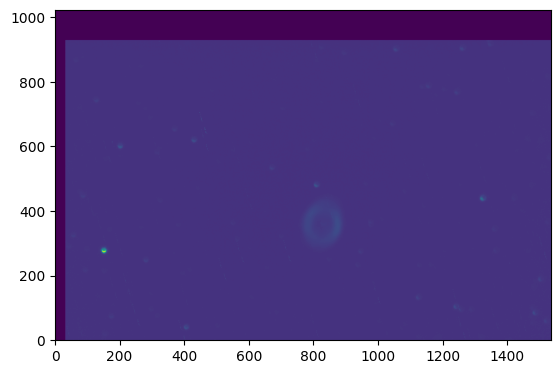

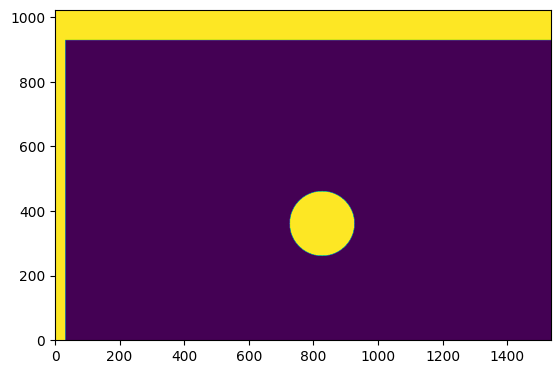

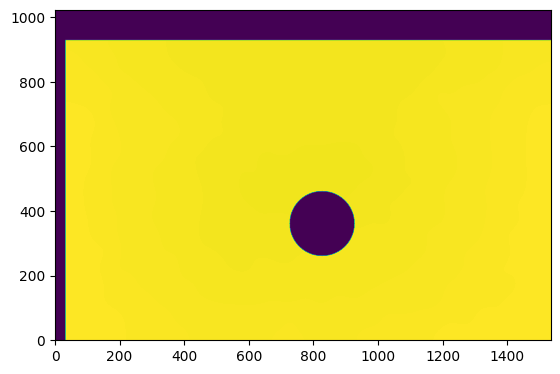

In [ ]:
# Green filter

mask_G=np.zeros(np.shape(shifted_G))
mask_G=mask_G.astype(bool)

# Set the Green mask
mask_G[distance <= radius] = True

# Additionally, set the mask to True for all pixels in data_B that are 0
mask_G[shifted_G == 0] = True

# Create background estimation
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg_G = Background2D(shifted_G, (50, 50), filter_size=(3, 3), sigma_clip=sigma_clip,
                     bkg_estimator=bkg_estimator, coverage_mask=mask_G)

# Find the pixels just outside the circle (10 pixels outside)
surrounding_mask = (distance > radius) & (distance <= radius + 10)

# Extract the pixel values from bkg_B.background in the surrounding region
surrounding_values = bkg_G.background[surrounding_mask]

# Calculate the average of these pixels
average_surrounding_value = np.mean(surrounding_values)
print(average_surrounding_value)

# Fill the circular region in bkg_B.background with the computed average
bkg_G.background[distance <= radius] = average_surrounding_value

print("      Median background found (Green): %f, median bkg noise: %f"
      %(bkg_G.background_median, bkg_G.background_rms_median))

plt.imshow(shifted_G, origin='lower')
plt.show()
plt.imshow(mask_G, origin='lower')
plt.show()
plt.imshow(bkg_G.background, origin='lower')
plt.show()

725.1504827436265
      Median background found (Blue): 725.597658, median bkg noise: 33.185778


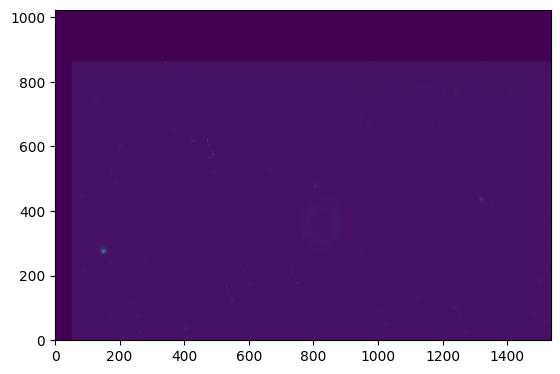

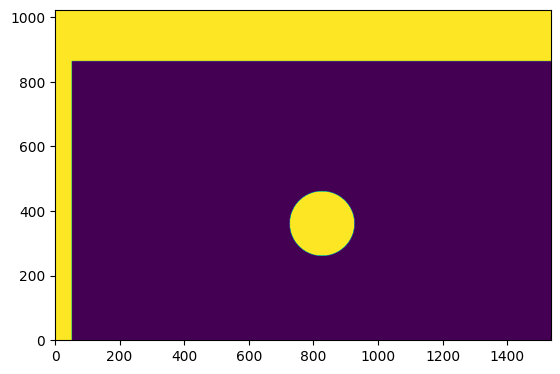

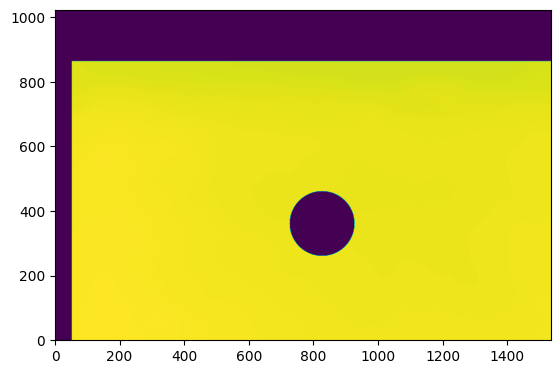

In [ ]:
# Blue filter

mask_B=np.zeros(np.shape(shifted_B))
mask_B=mask_B.astype(bool)

# Set the Blue mask
mask_B[distance <= radius] = True

# Additionally, set the mask to True for all pixels in data_B that are 0
mask_B[shifted_B == 0] = True

# Create background estimation
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg_B = Background2D(shifted_B, (50, 50), filter_size=(3, 3), sigma_clip=sigma_clip,
                     bkg_estimator=bkg_estimator, coverage_mask=mask_B)

# Find the pixels just outside the circle (10 pixels outside)
surrounding_mask = (distance > radius) & (distance <= radius + 10)

# Extract the pixel values from bkg_B.background in the surrounding region
surrounding_values = bkg_B.background[surrounding_mask]

# Calculate the average of these pixels
average_surrounding_value = np.mean(surrounding_values)
print(average_surrounding_value)

# Fill the circular region in bkg_B.background with the computed average
bkg_B.background[distance <= radius] = average_surrounding_value

print("      Median background found (Blue): %f, median bkg noise: %f"
      %(bkg_B.background_median, bkg_B.background_rms_median))

plt.imshow(shifted_B, origin='lower')
plt.show()
plt.imshow(mask_B, origin='lower')
plt.show()
plt.imshow(bkg_B.background, origin='lower')
plt.show()

In [ ]:
#calibration = [123.316731,0.00863632,0.04726095]
calibration = [2.55196689,2.03848835,5.86502613]
k = 0.005
new_data_R = (data_R - bkg_R.background_median) * calibration [0] * k
new_data_G = (shifted_G - bkg_G.background_median) * calibration [1] * k
new_data_B = (shifted_B - bkg_B.background_median) * calibration [2] * k

In [ ]:
new_data_R = (data_R - bkg_R.background_median) / bkg_R.background_rms_median
new_data_G = (shifted_G - bkg_G.background_median) / bkg_G.background_rms_median
new_data_B = (shifted_B - bkg_B.background_median) / bkg_B.background_rms_median

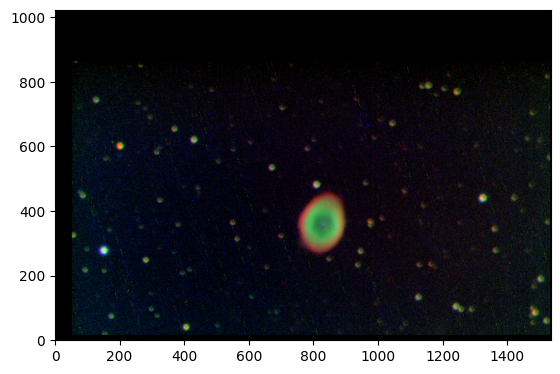

In [ ]:
# Create the RGB image using the original data
rgb_default = make_lupton_rgb(new_data_R, new_data_G, new_data_B)

# Remove the mask
h, w, c = rgb_default.shape

rgb_default[:mask_y2, :] = 0           # Rows above mask_y1
rgb_default[h + mask_y1 + 1:, :] = 0       # Rows below mask_y2
rgb_default[:, :mask_x2] = 0           # Columns left of mask_x1
rgb_default[:, w + mask_x1 + 1:] = 0       # Columns right of mask_x2

# Show final image
plt.imshow(rgb_default, origin='lower')
plt.show()

In [ ]:
# Define the filename for each shifted image (you can customize the naming scheme)
filename = f"{dir}m57_RGB.jpeg"

# Save the image as a JPEG
plt.imsave(filename, rgb_default, format='jpeg')

print(f"Saved: {filename}")

Saved: /content/sample_data/m57_RGB.jpeg
